In [1]:
import torch
import detectron2
import json
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.model_zoo import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2
import os
textline_detection_test_metadata = MetadataCatalog.get("textline_detection_test")


/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def textline_detection_get_cfg():
    '''
    Loads the Faster R-CNN configuration file from the model zoo, merges it with additional settings specific to the bar 
    detection, and returns the resulting configuration as a ConfigNode object.
    
    Returns:
        ConfigNode: A ConfigNode object containing the configuration settings for the Faster R-CNN model.
    '''
    cfg = get_cfg()
    # merge in configuration file for model
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    # adjust configuration settings for bar detection
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.TEST.DETECTIONS_PER_IMAGE = 100
    return cfg


In [4]:
def detect_objects(image_path, model_path, threshold=0.90):
    '''
    Detects objects in an image using a specified model and returns the bounding boxes as a list.
    
    Args:
        image_path (str): The path to the image file.
        model_path (str): The path to the trained model file.
        threshold (float, optional): The confidence threshold above which to consider an object detected. Defaults to 0.90.
    
    Returns:
        list: A list of bounding boxes for the detected objects. Each bounding box is represented as a list of four floats 
              corresponding to the (x1, y1, x2, y2) coordinates of the top-left and height and width of the bounding box.
    '''
    setup_logger()
    
    # Get configuration settings for Faster R-CNN model specific to bar detection
    textline_detection_cfg = textline_detection_get_cfg()
    
    # Set threshold for the model
    textline_detection_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    
    # Set path to the model
    textline_detection_cfg.MODEL.WEIGHTS = model_path
    
    # Create predictor object with the updated configuration settings
    predictor = DefaultPredictor(textline_detection_cfg)
    
    # Load image and use predictor to detect objects within the image
    im = cv2.imread(image_path)
    outputs = predictor(im)
    
    # Extract bounding boxes of detected objects and return as a list
    bounding_boxes = []
    for box in outputs["instances"].pred_boxes.tensor.tolist():
        bounding_boxes.append(box)
    return bounding_boxes


In [5]:
bounding_boxes = detect_objects(image_path = "textline_detection_data/textline_detection_images_test/1_region_2285_919_4309_7014.png", model_path = "output/model_final.pth")

/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/nachum/berat/anaconda3/envs/torchenv/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
bounding_boxes

[[38.541568756103516,
  432.6269226074219,
  393.50408935546875,
  461.63665771484375],
 [37.80038070678711,
  247.10023498535156,
  394.21307373046875,
  275.3734436035156],
 [35.88195037841797, 720.8863525390625, 391.2872619628906, 756.1179809570312],
 [42.23515701293945, 669.9360961914062, 391.37591552734375, 704.2755126953125],
 [42.44755172729492, 624.3080444335938, 390.3651123046875, 654.9371337890625],
 [39.514801025390625,
  599.5217895507812,
  395.47174072265625,
  630.5103759765625],
 [33.26011276245117, 578.7669067382812, 399.1248779296875, 607.6347045898438],
 [41.01217269897461, 921.3810424804688, 393.8795471191406, 951.523681640625],
 [44.02110290527344, 648.431884765625, 392.5269775390625, 678.2946166992188],
 [38.393394470214844,
  476.9053955078125,
  392.68927001953125,
  508.0327453613281],
 [27.839807510375977, 406.459228515625, 397.2041931152344, 435.4134216308594],
 [26.023265838623047,
  225.2139892578125,
  393.18865966796875,
  250.99069213867188],
 [29.844003

In [7]:
def show_objects(image_path, model_path, threshold=0.90):
    '''
    Displays an image with bounding boxes drawn around any detected objects.

    Args:
        image_path (str): The path to the image to be processed.
        model_path (str): The path to the trained model to use for object detection.
        threshold (float, optional): The minimum confidence threshold for detected objects. Default is 0.90.

    Returns:
        None: Displays the image with bounding boxes drawn around any detected objects.
    '''
    setup_logger()
    # Get configuration for bar detection
    textline_detection_cfg = textline_detection_get_cfg()
    # Set threshold for model
    textline_detection_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    # Load trained weights
    textline_detection_cfg.MODEL.WEIGHTS = model_path
    # Create predictor
    predictor = DefaultPredictor(textline_detection_cfg)
    # Load image
    im = cv2.imread(image_path)
    # Run inference on image
    outputs = predictor(im)
    # Visualize predictions
    v = Visualizer(im,
                   metadata=textline_detection_test_metadata, 
                   scale=1, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # Display image with bounding boxes
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')

    return


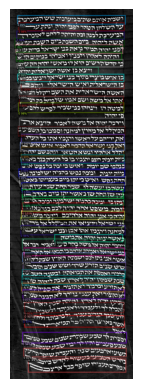

In [8]:
show_objects(image_path = "textline_detection_data/textline_detection_images_test/1_region_2285_919_4309_7014.png", model_path = "output/model_final.pth")

### Inference on full set of images

In [10]:
# Set the detection threshold and model path
threshold = 0.95
model_path = 'output/model_final.pth'

# Initialize the object detection model
setup_logger()
textline_detection_cfg = textline_detection_get_cfg()
textline_detection_test_metadata = MetadataCatalog.get("textline_detection_test")
textline_detection_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
textline_detection_cfg.MODEL.WEIGHTS = model_path
predictor = DefaultPredictor(textline_detection_cfg)

# Create directory for the visualized outputs
if not os.path.exists('output/visualized_predictions'):
    os.makedirs('output/visualized_predictions')

# Create an empty COCO annotations dictionary
coco = {"images": [], "annotations": [], "categories": []}

# Iterate through the images
for file_name in os.listdir("textline_detection_data/textline_detection_images_test"):
    print("Processing " + file_name)
    # Load the image
    img = cv2.imread(f"textline_detection_data/textline_detection_images_test/{file_name}")
    # Predict the bounding boxes
    outputs = predictor(img)
    # Save the visualization
    v = Visualizer(img,
                   metadata=textline_detection_test_metadata, 
                   scale=1, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite('output/visualized_predictions/'+file_name, out.get_image())
    # Get the predicted bounding boxes
    bboxes = outputs["instances"].pred_boxes.tensor.tolist()
    # Get the predicted class labels
    labels = outputs["instances"].pred_classes.tolist()
    # Add the image to the COCO annotations dictionary
    coco["images"].append({"file_name": file_name, "id": len(coco["images"]) + 1})
    # Add the predicted bounding boxes to the COCO annotations dictionary
    for bbox, label in zip(bboxes, labels):
        coco["annotations"].append({"image_id": len(coco["images"]), "bbox": bbox, "category_id": label})
    # Add the category labels to the COCO annotations dictionary
    if len(coco["categories"]) == 0:
        for label in set(labels):
            coco["categories"].append({"id": label, "name": f"class_{label}"})

# Save the COCO annotations to a json file
with open("output/textline_detection_test_predictions.json", "w") as f:
    json.dump(coco, f)

Processing 10_region_1112_384_1770_2135.png
Processing 10_region_2214_359_2889_2092.png
Processing 10_region_2914_333_3555_2092.png
Processing 10_region_438_376_1087_1520.png
Processing 11_region_2651_290_4430_5223.png
Processing 11_region_755_232_2573_5242.png
Processing 12_region_195_125_2372_3554.png
Processing 13_region_2318_318_3331_2633.png
Processing 13_region_650_280_1653_2585.png
Processing 15_region_1087_666_1434_2180.png
Processing 15_region_296_656_701_2199.png
Processing 15_region_691_666_1096_2161.png
Processing 16_region_2163_885_3160_3103.png
Processing 16_region_3866_863_4930_3574.png
Processing 16_region_4908_874_5927_3574.png
Processing 17_region_167_137_1123_1387.png
Processing 18_region_1813_1440_2750_4962.png
Processing 18_region_2848_1398_3896_4906.png
Processing 18_region_751_1440_1702_5004.png
Processing 19_region_234_95_406_517.png
Processing 19_region_46_111_218_523.png
Processing 1_region_2285_919_4309_7014.png
Processing 1_region_278_850_2165_7048.png
Proce